# Data Analyst Call Center Report
The original dataset can be found thanks to Kaggle: https://www.kaggle.com/datasets/satvicoder/call-center-data

The main things to analyze for the call center are:
1. Average Call Duration: Identify any outliers or excessively long calls.
2. Response Time: Evaluate the response time metrics, such as the average speed to answer calls or the average hold time. 
3. Agent Performance: Evaluate individual agent performance metrics, such as call handling time and call resolution rate
4. Call Abandonment Rate: Monitor the rate at which customers abandon calls before reaching an agent which should be done as a percent and sum of dropped calls.

Normally, one could analyze a customer feedback, however, in this dataset there is none given. 
Also, there is no timestamps so it is hard to detect call volumn from a times series pespective.

## Read Data

In [1]:
import numpy as np 
import pandas as pd 
file=r'/kaggle/input/call-center-data/Call Center Data.csv'

In [2]:
df=pd.read_csv(file)
print(len(df))
df.head(10)

1251


,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds)
0,1,217,204,94.01%,13,0:00:17,0:02:14,0:02:45,76.28%
1,2,200,182,91.00%,18,0:00:20,0:02:22,0:06:55,72.73%
2,3,216,198,91.67%,18,0:00:18,0:02:38,0:03:50,74.30%
3,4,155,145,93.55%,10,0:00:15,0:02:29,0:03:12,79.61%
4,5,37,37,100.00%,0,0:00:03,0:02:06,0:00:35,97.30%
5,6,315,304,96.51%,11,0:00:18,0:01:35,0:02:37,77.17%
6,7,252,244,96.83%,8,0:00:13,0:01:50,0:02:02,82.00%
7,8,213,205,96.24%,8,0:00:10,0:02:10,0:03:22,88.10%
8,9,219,200,91.32%,19,0:00:15,0:02:18,0:06:12,79.45%
9,10,371,348,93.80%,23,0:00:19,0:01:40,0:03:29,73.63%


## Missing Values 
There are luckily no missing values that we need to worry about.

In [3]:
percent_missing = df.isnull().sum() * 100 / len(df)
percent_missing

Index                         0.0
Incoming Calls                0.0
Answered Calls                0.0
Answer Rate                   0.0
Abandoned Calls               0.0
Answer Speed (AVG)            0.0
Talk Duration (AVG)           0.0
Waiting Time (AVG)            0.0
Service Level (20 Seconds)    0.0
dtype: float64

# Column Types
There are many columns that need to go into numeric form so we can use the data for further analysis. 

In [4]:
# There are many "time stamp" object types that will need to be converted into minutes as a floats or int.
# Also, there are percentiles object that need to be converted into floats. 
df.dtypes

Index                          int64
Incoming Calls                 int64
Answered Calls                 int64
Answer Rate                   object
Abandoned Calls                int64
Answer Speed (AVG)            object
Talk Duration (AVG)           object
Waiting Time (AVG)            object
Service Level (20 Seconds)    object
dtype: object

In [5]:
# Change the wait time which in object time form into minutes:
df['Wait Time Minutes(AVG)'] = df['Waiting Time (AVG)'].apply(lambda x: sum(int(i) * 60 ** index for index, i in enumerate(x.split(':')[::-1])) // 60)
df['Talk Duration Minutes(AVG)'] = df['Talk Duration (AVG)'].apply(lambda x: sum(int(i) * 60 ** index for index, i in enumerate(x.split(':')[::-1])) // 60)
# Note: This code is complex and it took me a while to get correct even with ChatGPT. This version is accurate than how ChatGPT original.

In [6]:
# Change these two objects as a percent into an int value:
df['Answer Rate'] = df['Answer Rate'].str.rstrip('%').astype(float)
df['Service Level (20 Seconds)'] = df['Service Level (20 Seconds)'].str.rstrip('%').astype(float)

# Abandon Calls
Using PowerBI/Tablaeu, we can clearly see a trend in service levels and abandoned calls. Since p is < .0001 it means that there is a strong significance between abandon calls and service level.
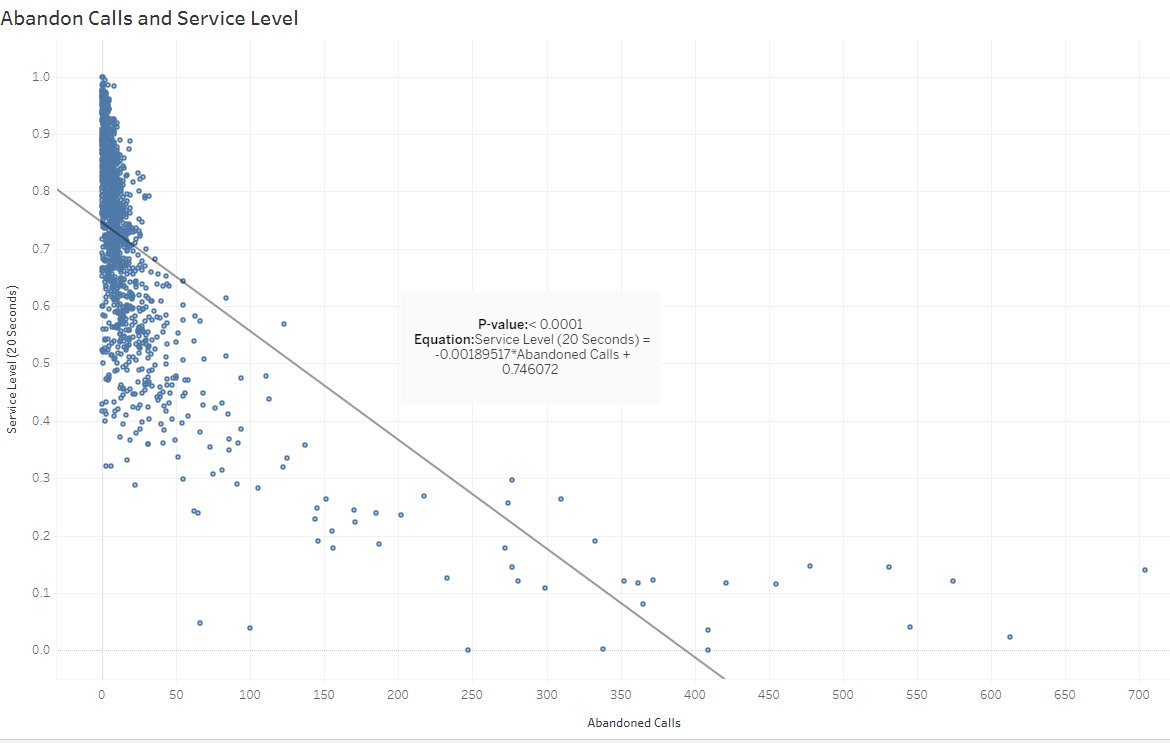


Many reps in the 700 to 950 range have lots of dropped calls, further investigation needed.
Will created a calculated field to get results as a percent (number of calls divided by dropped calls). 
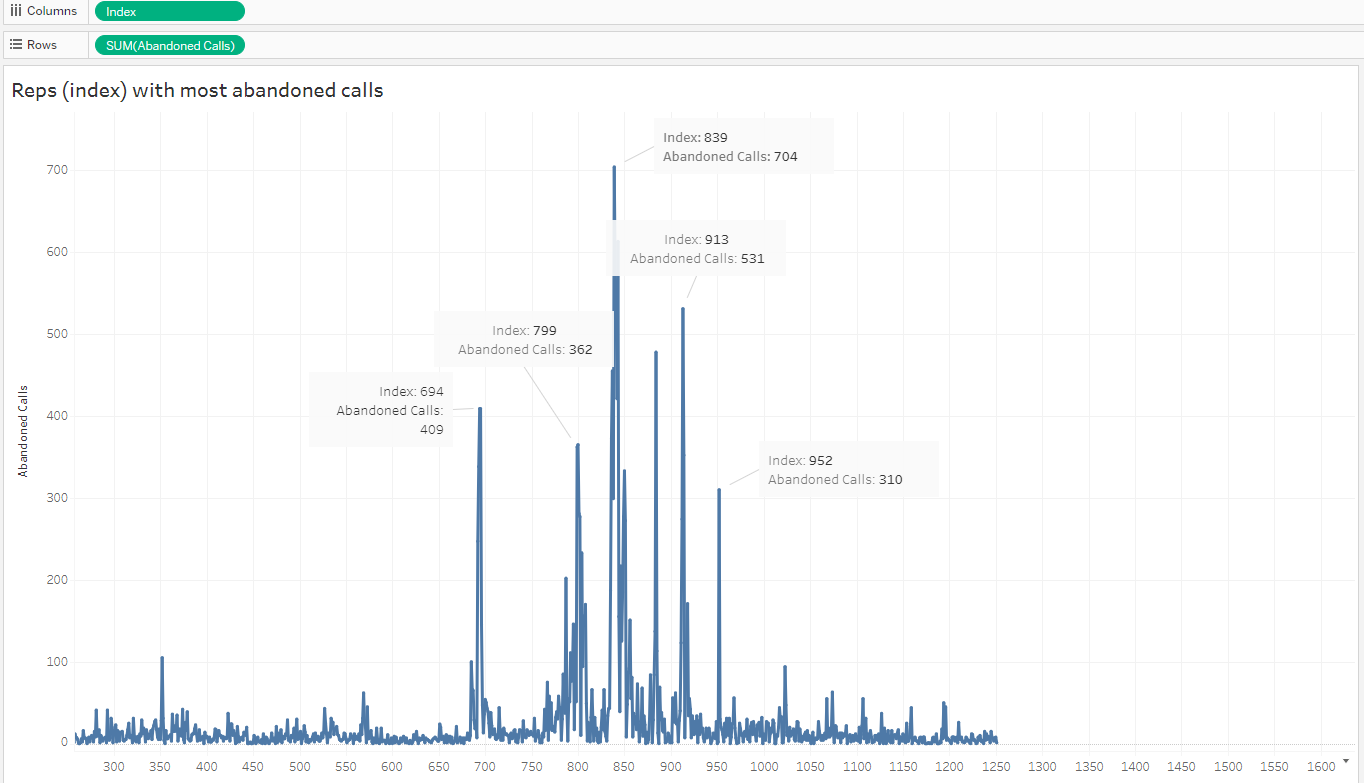
Lots of investiation needs to be done on these top 25 index with very high abandon percentages. 

I created a calculated field by doing dropped calls divided by incoming calls.
This should give a good visualization of areas that have high dropped calls:
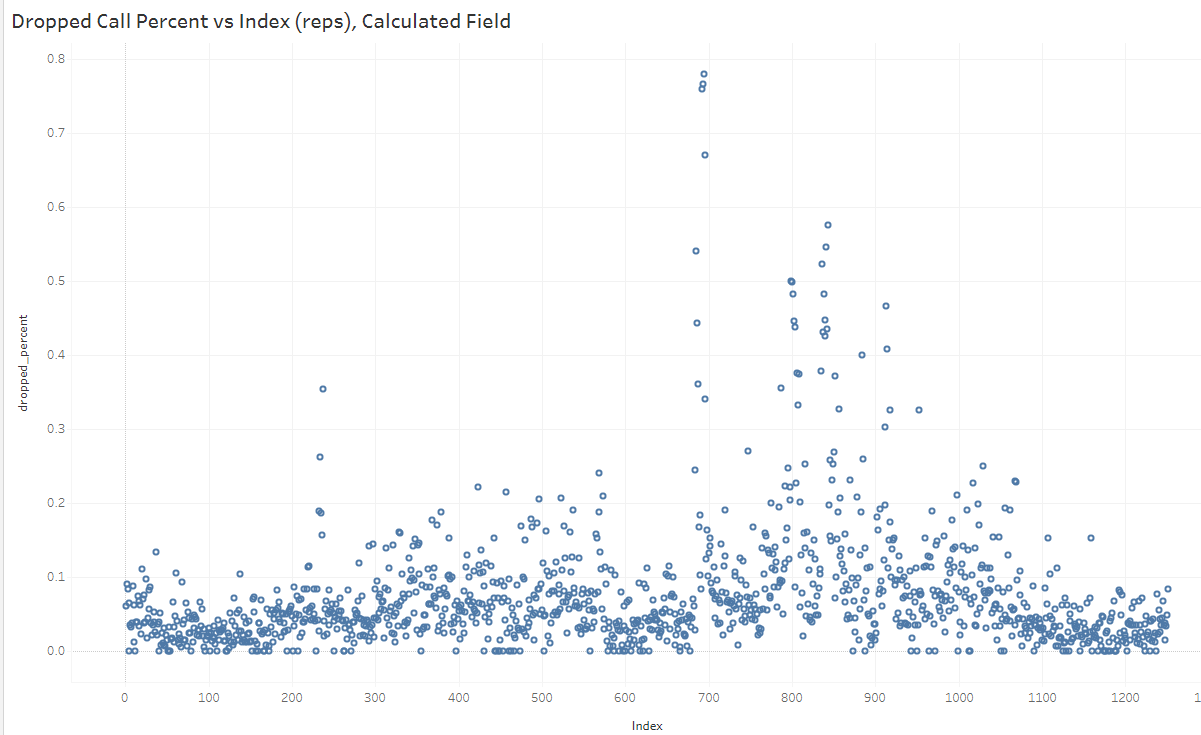

In [7]:
# Transform into a percent:
df['Abandoned_perc']=df['Abandoned Calls']/df['Answered Calls']
df['Abandoned_perc']=df['Abandoned_perc'].round(4)
abandonDF=df[['Index', 'Abandoned_perc', 'Waiting Time (AVG)']].sort_values(by=['Abandoned_perc'], ascending=False)
abandonDF.head(25)

,Index,Abandoned_perc,Waiting Time (AVG)
693,694,3.5259,0:22:56
692,693,3.2816,0:15:38
691,692,3.1667,0:17:27
694,695,2.0348,0:19:15
842,843,1.3532,0:22:37
840,841,1.2004,0:13:24
684,685,1.1765,0:11:01
835,836,1.0941,0:16:25
798,799,1.0000,0:12:18
799,800,0.9946,0:16:38


In [8]:
corr=df['Abandoned_perc'].corr(df['Wait Time Minutes(AVG)'])
print(corr.round(4), " correlation between wait time and abandon calls")

0.6406  correlation between wait time and abandon calls


# Bottle Necks
Below are three reps (index) that seem to have long wait times. 
Further investigation needed. 

In [9]:
df.iloc[[694]]

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
694,695,610,201,32.95,409,0:03:13,0:02:52,0:19:15,3.52,19,2,2.0348


In [10]:
df.iloc[[693]]

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
693,694,525,116,22.1,409,0:05:08,0:03:08,0:22:56,0.0,22,3,3.5259


In [11]:
df.iloc[[692]]

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
692,693,441,103,23.36,338,0:04:04,0:02:43,0:15:38,0.23,15,2,3.2816


# Outlier
Certain reps might have longer times than others, but assuming each index has the same job title they should  be similair to the mean. Below will detect outliers for index (reps) that have too long or too short phone calls from the average mean.

In [12]:
# Calculate Z-scores
z_scores = np.abs((df['Talk Duration Minutes(AVG)'] - df['Talk Duration Minutes(AVG)'].mean()) / df['Talk Duration Minutes(AVG)'].std())

# Set a threshold (e.g., 2 or 3 standard deviations)
threshold = 3

# Detect outliers
outliers = df[z_scores > threshold]
outliers

,Index,Incoming Calls,Answered Calls,Answer Rate,Abandoned Calls,Answer Speed (AVG),Talk Duration (AVG),Waiting Time (AVG),Service Level (20 Seconds),Wait Time Minutes(AVG),Talk Duration Minutes(AVG),Abandoned_perc
184,185,483,451,93.37,32,0:00:16,0:00:57,0:08:45,79.20,8,0,0.0710
571,572,18,17,94.44,1,0:00:55,0:04:01,0:05:46,50.00,5,4,0.0588
800,801,582,301,51.72,281,0:02:41,0:04:13,0:21:42,12.08,21,4,0.9336
802,803,116,106,91.38,10,0:00:34,0:04:23,0:04:44,62.93,4,4,0.0943
803,804,533,300,56.29,233,0:02:12,0:04:03,0:12:24,12.55,12,4,0.7767
972,973,7,6,85.71,1,0:00:03,0:04:48,0:00:31,85.71,0,4,0.1667


# Time Series Trends
Using a second call center Kaggle time series dataset: https://www.kaggle.com/datasets/anirbank/sanfrancisco-311-monthly-call-metrics

Here is a continious calls by year and month:
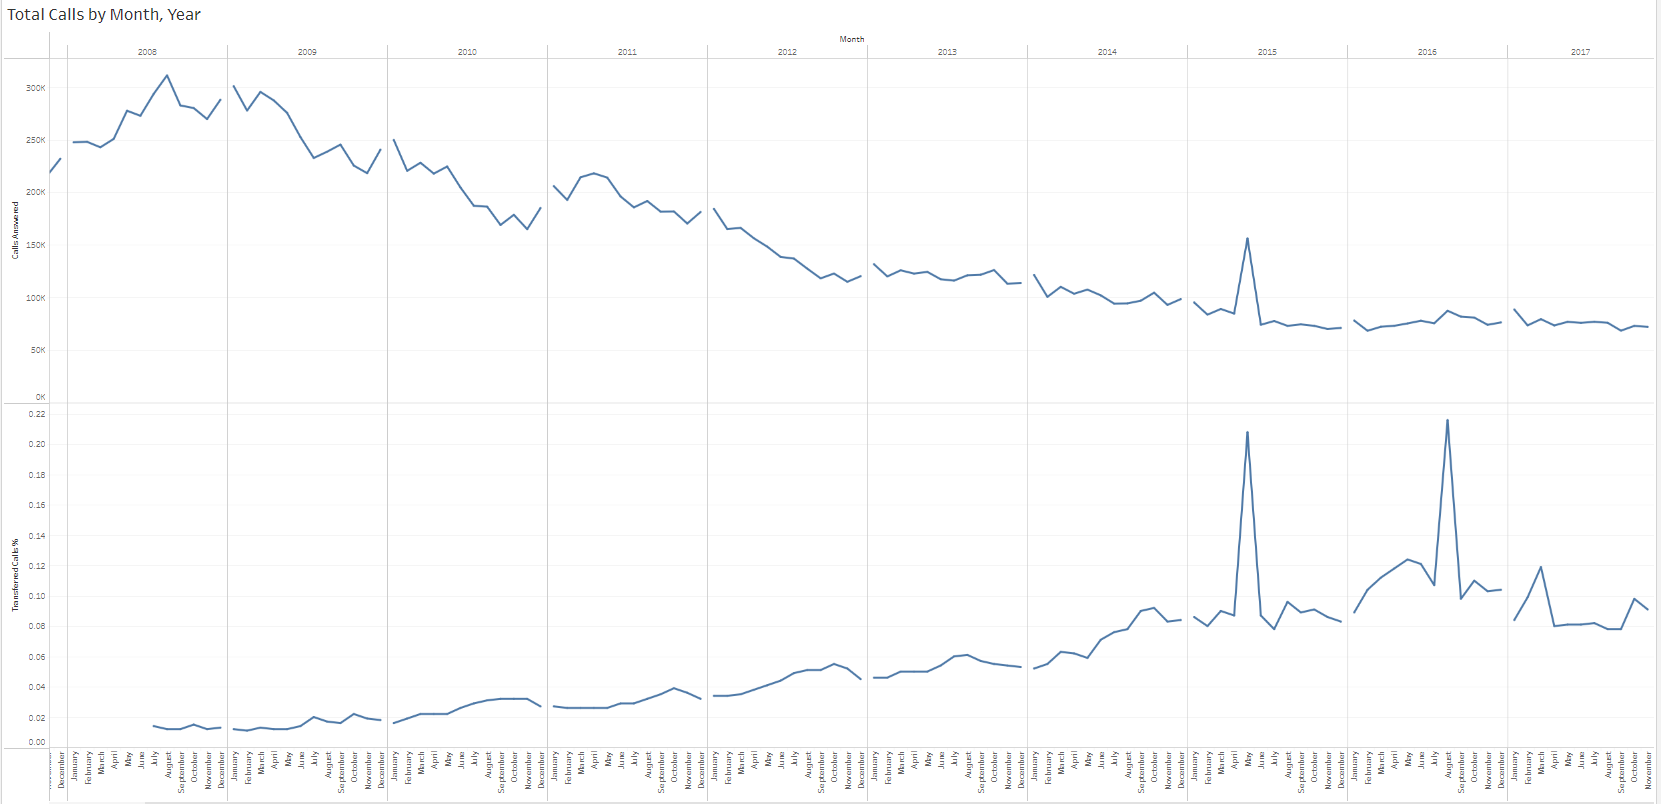

The trend is much easier to see on a yearly basis below:

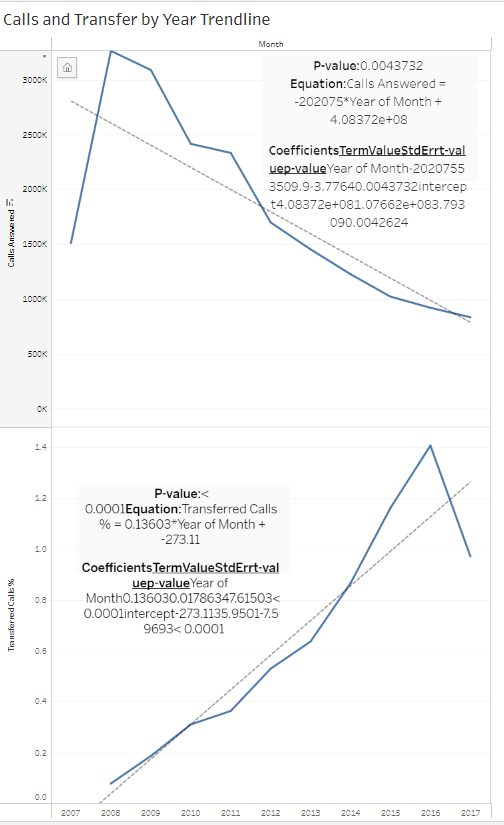

Monthly trends graph:
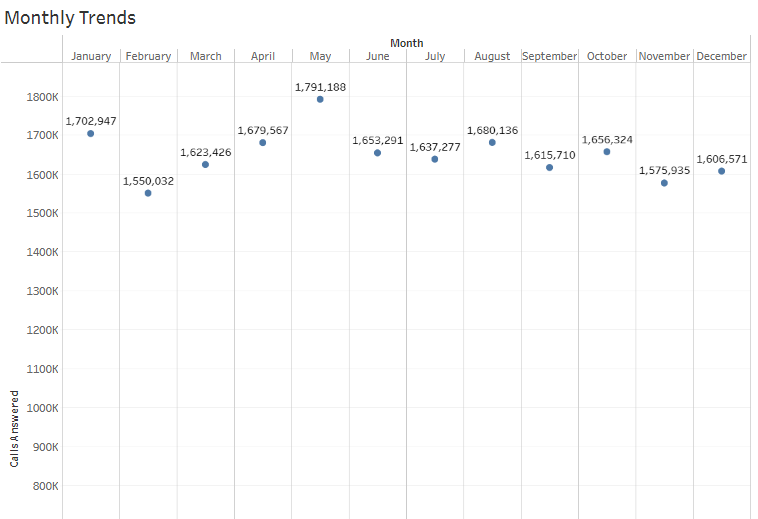